# MAC0318 Introdu√ß√£o √† Programa√ß√£o de Rob√¥s M√≥veis

Vamos agora assumir que nosso **dom√≠nio √© a reta real**, ou seja, que o agente navega em um ambiente e seu estado √© representado pela vari√°vel aleat√≥ria $X_t$ cujo  suporte √© $\mathbb{R}$. Para esse caso, nossa cren√ßa √© uma **fun√ß√£o de densidade** e portanto n√£o podemos mais represent√°-la como um vetor de tamanho finito. Para tanto, vamos adotar um filtro de histograma, que retringe o suporte da fun√ß√£o de cren√ßa a um conjunto finito de **centr√≥ides**.

In [1]:
# Vamos carregar as bibliotecas necess√°rias

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Filtro de histograma

O filtro de histograma representa a cren√ßa como uma som√°toria de [fun√ß√µes de Dirac](https://en.wikipedia.org/wiki/Dirac_delta_function) centradas em pontos $x_1,\ldots,x_N$ chamados de centr√≥ides:
$$
 \text{bel}_t(x) = \sum_{c=1}^N w_{c,t} \delta(x - x_c) .
$$
Para que a fun√ß√£o acima seja uma densidade devemos satisfazer
$$
 \int_{-\infty}^{\infty} \text{bel}_t(x) dx = 1 \Rightarrow \sum_c w_{c,t} \int_{-\infty}^{\infty} \delta(x-x_c) dx = \sum_c w_{c,t} = 1 .
$$
e
$$
 \text{bel}_t(x) \geq 0 \Rightarrow w_{c,t} \geq 0 .
$$
Na deriva√ß√£o acima usamos a propriedade das fun√ß√µes de Dirac:
$$
 \int_{-\infty}^{\infty} \delta(x-x_c) dx = 1 .
$$

Definimos as posi√ß√µes dos centr√≥ides especificando um intervalo $[x_\min, x_\max]$ e uma quantidade de pontos $N$. Note que nossa cren√ßa sempre atribu√≠ probabilidade zero para qualquer estado fora desse intervalo, portanto √© preciso escolher o intervalo de maneira adequada.

In [2]:
xmin, xmax = 0, 10
N = 10
centroides = np.linspace(xmin,xmax,N)

Vamos escrever uma fun√ß√£o para representar visualmente a fun√ß√£o de cren√ßa.

In [3]:
def show_belief(b):
    b = b.flatten()
    states = plt.bar(centroides, b)
    plt.xticks(centroides)
    plt.ylim([0, 1])
    plt.ylabel('bel(X)')
    plt.xlabel('X')
    plt.title('Cren√ßa')

Vamos supor uma cren√ßa uniforme (m√°xima ignor√¢ncia). Note que a largura das barras s√£o apenas para visualiza√ß√£o; a fun√ß√£o de cren√ßa define uma densidade n√£o nula apenas nos centr√≥ides. A fun√ß√£o de cren√ßa √© representada pelo vetor de pesos $w_1, \ldots, w_N$.

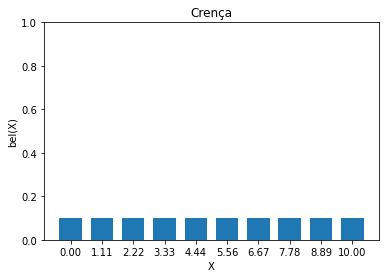

In [4]:
bel = (1/N)*np.ones(N)

show_belief(bel)

In [5]:
# Teste de consist√™ncia

bel.sum()

1.0

### Modelo de sensor

Vamos tamb√©m supor que dispomos de um **sensor imperfeito** que nos fornece a posi√ß√£o do rob√¥ com alguma precis√£o. Em particular, vamos assumir que o erro do sensor √© modelado por uma vari√°vel gaussiana com m√©dia 0 e vari√¢ncia $\sigma^2$:
$$
    p(y|X_t=x) = \mathcal{N}(x, \sigma^2) .
$$

Note que agora tanto a vari√°vel de estado quanto a vari√°vel de observa√ß√£o s√£o cont√≠nuas, e portanto, suas vari√°veis aleat√≥rias possuem fun√ß√µes de densidades associadas (ao inv√©s de distribui√ß√µes de massa de probabilidade).

In [6]:
sigma2 = 1.5

def sensor(y, x): 
    ''' Return p(y|X=x). '''
    return norm.pdf(y, loc=x, scale=np.sqrt(sigma2))

Por exemplo, quando estamos em $X_t = 2$, nosso sensor retorna valores de acordo com a fun√ß√£o de densidade abaixo

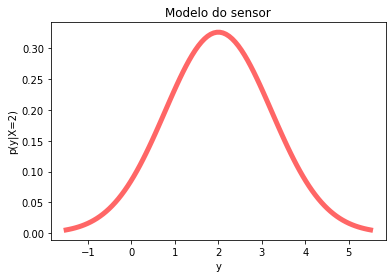

In [7]:
yspace = np.linspace(-1.5, 5.5, 100)
plt.plot(yspace, [sensor(y,2) for y in yspace], 'r-', lw=5, alpha=0.6);
plt.ylabel('p(y|X=2)');
plt.xlabel('y');
plt.title('Modelo do sensor');

### Corre√ß√£o

A atualiza√ß√£o da cren√ßa para uma observa√ß√£o $Y_t=y$ √© dada por:

$$
\begin{align}
    \text{bel}_{t+1}(x) &= p(x|y) \\
    & = \frac{p(y | x)\text{bel}_t(x)}{p(y)} \\
    & = \eta p(y|x) \sum_{c=1}^N w_{c,t}  \delta(x-x_c) ,
\end{align}
$$
onde $\eta$ √© uma constante de normaliza√ß√£o. 
Pela defini√ß√£o da fun√ß√£o de Dirac, a equa√ß√£o acima √© nula para qualquer estado diferente de um centr√≥ide, $x \neq x_c$. E para um centr√≥ide $x=x_c$, a equa√ß√£o se torna
$$
\text{bel}_{t}(x_c) = \eta p(y|x_c) w_{c,t} .
$$
A nova cren√ßa portanto tem a mesma forma anterior:
$$
    \text{bel}_{t+1}(x) = \sum_{c=1}^N w_{c,t+1}  \delta(x-x_c) ,
$$
com os novos pesos calculados por
$$
w_{c,t+1} = \eta p(y|x_c) w_{c,t}
$$
e
$$
 \eta = \sum_{c=1}^N  p(y|x) w_{c,t} .
$$
Note que do ponto de vista computacional, a atualiza√ß√£o √© similar ao filtro bayesiano discreto: computamos o produto ponto-a-ponto da cren√ßa antiga pelo modelo de sensor em cada centr√≥ide e renormalizamos o vetor resultante. 

In [8]:
def correct(b, y):
    ''' Update belief vector b given observation y -- Calls sensor model sensor(y) = p(Y=y|x).  '''
    tilde_bel = np.array([sensor(y,x) for x in centroides]).T # p(Y=y|X=x)
    tilde_bel *= b # bel(X) * p(y|X)
    # normaliza e atualiza vetor de cren√ßa
    b[:] = tilde_bel/np.sum(tilde_bel) 

Vamos testar o algoritmo supondo uma observa√ß√£o de $y=0.9$

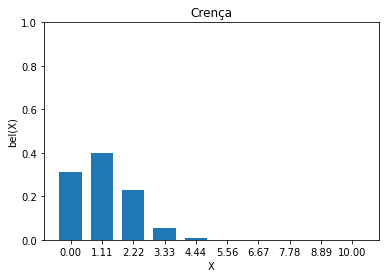

In [9]:
# observa Y=0.9

correct(bel, 0.9)

show_belief(bel) 

Note como a nova cren√ßa se concentra ao redor do valor medido, reflentindo uma redu√ß√£o da incerteza (entropia) da estima√ß√£o de estado.

### Modelo de transi√ß√£o

Para o modelo de transi√ß√£o, vamos assumir que o rob√¥ executa uma a√ß√£o de se mover $u$ unidades em um intervalo $[-1,1]$, e que o rob√¥ se movimenta de acordo com o seguinte modelo:

$$
  x_{t+1} = x_t + u + k*u*\epsilon
$$

com $\epsilon$ sendo uma vari√°vel gaussiana com m√©dia 0 e vari√¢ncia 1. A constante $k$ regular a vari√¢ncia da imprecis√£o do movimento. A fun√ß√£o de densidade da transi√ß√£o dessa forma √© dada por
$$
p(x_{t+1} | x_t, u) = \mathcal{N}(x_t + u, k^2 u^2) .
$$

In [10]:
k = 1.0 # regula vari√¢ncia no movimento

### Predi√ß√£o

A etapa de atualiza√ß√£o da cren√ßa para uma dada a√ß√£o $u$ √© obtida por:
$$
\begin{align}
  \text{bel}_{t+1}(x') &= \int_{-\infty}^{\infty} p(x' | X_t=x, u) \text{bel}_t(x) dx \\
  & = \int_{-\infty}^{\infty} p(x' | X_t=x, u) \sum_{c} w_{c,t} \delta(x-x_c) dx \\
  & =   \sum_{c} w_{c,t} \int_{-\infty}^{\infty} p(x' | X_t=x, u) \delta(x-x_c) dx \\
  & =  \sum_{c} w_{c,t} p(x' | X_t=x_c, u).
\end{align}
$$
Note que a equa√ß√£o acima atribui densidade a qualquer ponto $x'$ do espa√ßo, violando nossa hip√≥tese inicial (ou seja, a forma funcional do filtro n√£o √© fechada sobre a opera√ß√£o de predi√ß√£o acima). Para recuperarmos a propriedade inicial, vamos impor que
$$
\text{bel}_{t+1}(x') = \sum_{c=1}^N w_{c,t+1} \delta(x-x_c) .
$$
Igualando as duas equa√ß√µes temos que:
$$
w_{c',t+1} = \sum_{c=1}^N w_{c,t} p(x_{c'} | X_t=x_c, u) .
$$
Ou seja, cada novo peso √© a convolu√ß√£o da cren√ßa anterior e da fun√ß√£o de transi√ß√£o. Note que a fun√ß√£o de transi√ß√£o dentro da soma acima √© calculada apenas em centr√≥ides. Dessa forma, podemos represent√°-la por uma matriz $T$ de tamanho $N$-por-$N$ tal que $T(x_i,x_j) = p(x_i|x_j,u)$. Para garantirmos que os novos pesos $w_{c'}$ somem um, √© suficiente que as colunas de $T$ somem um. Dessa forma, obtemos a mesma representa√ß√£o do filtro bayesiano discreto e computamos a nova cren√ßa $w_{\cdot,t+1}$ (novos pesos) como o produto matricial da matriz de transi√ß√£o $T$ e a cren√ßa antiga (pesos antigos) $w_{\cdot, t}$. A √∫nica diferen√ßa aqui, √© que precisamos construir a matriz a partir do valor $u$, dado que $u$ √© cont√≠nuo.

Tal similaridade com o filtro bayesiano discreto n√£o √© acidental. De fato, outra maneira de derivar o filtro de histograma √© considerar uma discretiza√ß√£o do espa√ßo de estados em c√©lulas nas quais a densidade √© constante √© possui valor proporcional ao da densidade no centr√≥ide. Nesse caso, os pesos $w_c$ s√£o interpretados como a probabilidade do estado pertencer √† regi√£o $c$, e as integrais s√£o substitu√≠das por somas como no filtro bayesiano discreto.

In [11]:
T = np.zeros((N,N)) # vamos criar uma matriz global para poupar recursos

def compute_transition_matrix(u):
    ''' Update transition matrix representing T[i,j] = p(X[t+1] = xi | X[t] = xj, U = u). '''
    for j in range(N):
        T[:,j] = norm.pdf(centroides, loc=centroides[j]+u, scale=k*u)
        T[:,j] /= T[:,j].sum()

In [12]:
def predict(b, u):
    ''' Update belief given action u. '''
    # First we update the transition matrix with the given control value
    compute_transition_matrix(u)
    # Now we update the belief weights
    b[:] = T @ b

Vamos testar para uma a√ß√£o $u=2$

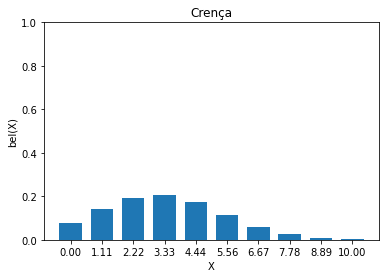

In [13]:
u = 2

predict(bel, u)

show_belief(bel)

In [14]:
# Consist√™ncia

bel.sum()

1.0000000000000002

Note que a cren√ßa sobre o estado se desloca 2 unidades para a direita e se "dilue", refeltindo um aumentando na incerteza (entropia) da estima√ß√£o de estado. Se dermos um passo menor, o aumento na incerteza √© menor, como especificado pelo modelo de transi√ß√£o.

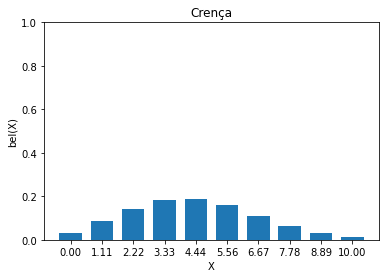

In [15]:
u = 1

predict(bel, u)

show_belief(bel)

In [16]:
bel.sum()

1.0000000000000002

Agora, se observamos $Y=3$, nossa incerteza sobre o estado diminui:

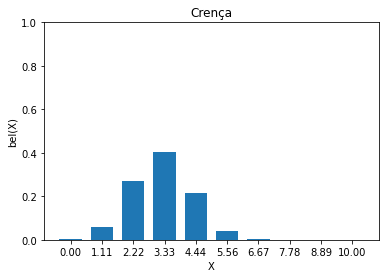

In [17]:
# observa Y=3

correct(bel, 3.0)

show_belief(bel) 

Para repassarmos a estima√ß√£o de estado para um controlador, precisamos produzir um valor representativo ou estat√≠stica da distribui√ß√£o. Novamente, vamos ver as duas formas mais comuns: moda e m√©dia.

In [18]:
def get_mode(b):
    ''' Extract most probable belief state. '''
    i = np.argmax(b) # distribution mode
    return centroides[i]

def get_mean(b):
    ''' Extract mean belief state value. '''
    return (centroides*b).sum()

In [19]:
x = get_mode(bel)
print('Mode state:', x)
x = get_mean(bel)
print('Mean state:', x)

Mode state: 3.3333333333333335
Mean state: 3.2331176865423212


## üí°Sua vez

Nossa deriva√ß√£o do filtro de histograma em duas etapas, corre√ß√£o e predi√ß√£o, √© desnecess√°ria e ineficiente. Na pr√°tica, atualizamos a cren√ßa em cada ciclo de atualiza√ß√£o do rob√¥, considerando a dist√¢ncia percorrida (velocidade vezes tempo decorrido) e obtendo uma observa√ß√£o.

Escreva a fun√ß√£o `update` condensando as duas etapas em uma s√≥. Note que s√≥ precisamos normalizar os pesos ao final. Use sua fun√ß√£o para simular um rob√¥ tomando a√ß√µes aleat√≥rias $u \in [-1,1]$ e observa√ß√µes uniformes $y \in [x-1, x+1]$.

In [20]:
def update(b, y, u):
    ''' Updates belief weights b with observation y and action u. '''
    # TODO

In [22]:
x = 3 # estado inicial -- atualize estado com valor "verdadeiro" para produzir observa√ß√£o

u = 2*np.random.random()-1 # Para gerar valor aleat√≥rio em [-1,1]
y = x + 2*np.random.random()-1

In [23]:
x, u, y

(3, 0.36483341523251767, 2.0396251515188415)